# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.066916,True,4.902346
1,-0.644360,True,6.220749
2,0.477774,True,4.098452
3,0.677380,True,5.596986
4,0.774406,True,6.582154
...,...,...,...
995,-1.025847,False,-0.753912
996,0.867778,True,6.023399
997,-1.070748,False,-0.605593
998,-1.346549,False,0.682342


<AxesSubplot: xlabel='v0'>

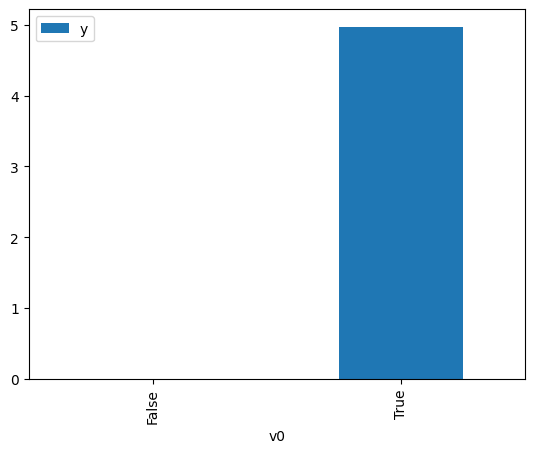

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

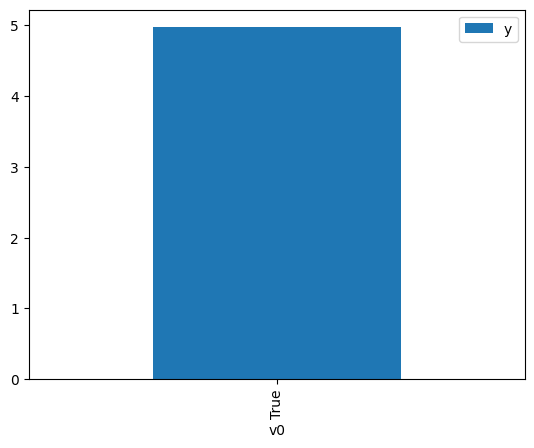

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.045262,False,-1.988535,0.501571,1.993735
1,0.782638,False,0.999790,0.224133,4.461641
2,0.113033,False,-2.232524,0.442175,2.261547
3,-0.205366,False,1.392362,0.561594,1.780645
4,-0.168479,False,1.705050,0.547860,1.825282
...,...,...,...,...,...
995,-1.590473,False,-2.357884,0.911785,1.096749
996,-1.600130,False,-1.556615,0.912949,1.095351
997,-0.088449,False,0.299121,0.517839,1.931101
998,-0.934484,False,-0.482812,0.793598,1.260083


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.136422,True,5.262490,0.566503,1.765216
1,0.284968,True,5.765385,0.620466,1.611693
2,-1.322432,True,3.888894,0.126577,7.900339
3,0.003051,True,3.566810,0.516630,1.935620
4,1.535764,True,6.058258,0.915061,1.092824
...,...,...,...,...,...
995,-0.429772,True,6.473912,0.357572,2.796642
996,-1.294993,True,2.729078,0.131221,7.620733
997,-0.463074,True,6.361547,0.346124,2.889136
998,0.309155,True,5.229049,0.629013,1.589792


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                              6218.
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:01:31   Log-Likelihood:                         -1426.3
No. Observations:                1000   AIC:                                      2857.
Df Residuals:                     998   BIC:                                      2866.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5357      0.032     16.751      0.000       0.473       0.598
x2             5.0041      0.049    102.660      0.000       4.908       5.100
==============================================================================
Omnibus:                        1.050   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                0.935
Skew:                          -0.004   Prob(JB):                        0.627
Kurtosis:                       3.150   Cond. No.                         1.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""